<p style="text-align:center">
    <a href="https://nbviewer.jupyter.org/github/twMr7/PyTorch-Deep-Learning/blob/master/04-Classic_CNN_Backbones_and_Transfer_Learning.ipynb">
        Open In Jupyter nbviewer
        <img style="float: center;" src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" width="120" />
    </a>
</p>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/twMr7/PyTorch-Deep-Learning/blob/master/04-Classic_CNN_Backbones_and_Transfer_Learning.ipynb)

# 4. Classic CNN Backbones and Transfer Learning

自從 2012 年 AlexNet 引起新一波人工智慧的熱潮，短短幾年之間，陸續又出現了幾個[創新的 CNN 架構](https://www.paperswithcode.com/sota/image-classification-on-imagenet)。 這些架構優異的物件辨識能力，以及經過 ImageNet 大量資料訓練過的參數，使得這些模型成為後續許多應用用來擷取影像特徵的骨幹。

+ [**4.1 AlexNet**](#alex-net)
    - [*AlexNet 結構*](#alexnet-architecture)
    - [*AlexNet model in torchvision*](#alexnet-model)
+ [**4.2 VGG**](#vgg-net)
    - [*VGG model in torchvision*](#vgg-model)
+ [**4.3 GoogLeNet (Inception)**](#google-net)
    - [*1×1 Convolution*](#1x1-conv)
    - [*Inception 基本結構*](#inception-architecture)
    - [*GoogleNet model in torchvision*](#googlenet-model)
+ [**4.4 ResNet**](#res-net)
    - [*ResNet 基本結構*](#resnet-architecture)
    - [*ResNet model in torchvision*](#resnet-model)
+ [**4.5 Transfer Learning**](#transfer-learning)

+ [**參考資料**](#references)


In [1]:
# 輔助圖片顯示及嵌入 notebook
from IPython.display import Image

---

<a id="alex-net"></a>

## 4.1 AlexNet

**AlexNet** [[3]](#references) 是 [ILSVRC 2012](https://image-net.org/challenges/LSVRC/2012/) 的獲勝模型，成績達到 top-5 error $15.3 \%$。 ImageNet 資料集的影像大小解析度不一，因此前處理首先統一將輸入資料 down-sampling 為 $256 \times 256$ 的三個 channel 影像，方法是先以最短邊為基準比例調整到$256$，再裁切中間 $256 \times 256$ 的區域。

### § 特點

####  Data Augmentation 資料擴增

資料集越大愈能減少 overfitting，影像資料最常見有效又簡單的手法，就是保持標籤不變對影像進行轉換處理。 AlexNet 在 $256 \times 256$ 大小的影像中，擷取其中隨機 $224 \times 224$ 大小的區域，以及其水平鏡像翻轉的影像，藉此擴大了 2048 倍的訓練集。 測試時也會從輸入 $256 \times 256$ 大小的影像中，分別擷取四個角落和中間 $224 \times 224$ 大小以及其水平鏡像翻轉的區域，總共十個影像取平均預測結果。

#### ReLU

AlexNet 全部使用 **ReLU (Rectified Linear Unit)** activation，據研究指出與傳統的 tanh 或 sigmoid 比起來，使用 ReLU 可以加速訓練的收斂速度，這對使用大型的訓練資料集尤其重要。

#### Dropout

AlexNet 在訓練時，前兩個全連階層的 activation 之後會套用 **Dropout** 的技巧來進一步降低 overfitting。 每個神經元都有 $0.5$ 的機率（超參數）會被丟棄（參數權重設為 $0$），被丟棄的神經元對 forward 或 backward 傳導不會再有任何貢獻，藉此降低網路的複雜度。 注意驗證及測試時不會再套用 隨機 dropout，但會將神經元輸出乘以 $0.5$ 來概略近似 dropout 的預測分布。

#### 其他

原文提及前兩個捲積層在 ReLU 之後 Pooling 之前作了 local Normalization，但後續的研究發現其實並沒有什麼特別效果，因此通常在重現模型的實作時被忽略。 另外，AlexNet 使用了兩個 GPU 進行訓練，作者在另外一篇論文 [[4]](#references) 有較詳盡描述使用多個 GPU 訓練時的幾種方式。


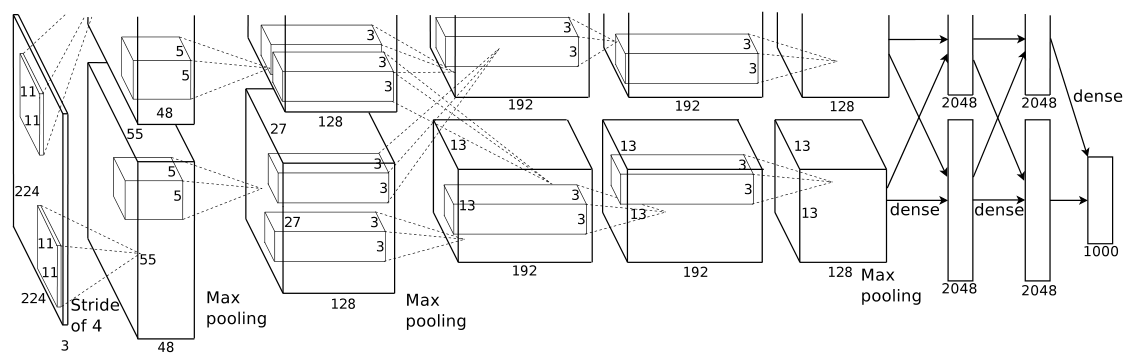

In [4]:
Image(filename='images/alexnet_architecture.png', width=800)


<a id="alexnet-architecture"></a>

### § AlexNet 結構

以下說明 AlexNet 網路的架構，使用符號說明如下：
- $f$: filter，濾波器 kernel 大小，通常用一個整數代表長與寬（大小相等），通道數固定與輸入相同。
- $s$: stride，濾波操作時，尋訪像素的移動間隔。
- $p$: padding，邊緣填充大小，通常也用一個整數代表。

**AlexNet** 是八層的 CNN 網路結構，包含了五個捲積層（**`conv1`**, **`conv2`**, **`conv3`**, **`conv4`**, **`conv5`**），三個全連結層（**`fc1`**, **`fc2`**, **`fc3`**）。

1. **`conv1`**： 輸入影像 $227 \times 227 \times 3$，使用 $96$ 個 kernal，$f=11$，$s=4$，$p=2$。
    + $\to$ *activation*: `relu`
    + $\to$ *pooling*: `max_pool`，$f=3$，$s=2$，$p=0$。
    +
2. **`conv2`**： 輸入 $27 \times 27 \times 96$，使用 $256$ 個 kernal，$f=5$，$s=1$，$p=2$。
    + $\to$ *activation*: `relu`
    + $\to$ *pooling*: `max_pool`，$f=3$，$s=2$，$p=0$。
    +
3. **`conv3`**： 輸入 $13 \times 13 \times 256$，使用 $384$ 個 kernal，$f=3$，$s=1$，$p=1$。
    + $\to$ *activation*: `relu`
    +
4. **`conv4`**： 輸入 $13 \times 13 \times 384$，使用 $384$ 個 kernal，$f=3$，$s=1$，$p=1$。
    + $\to$ *activation*: `relu`
    +
5. **`conv5`**： 輸入 $13 \times 13 \times 384$，使用 $256$ 個 kernal，$f=3$，$s=1$，$p=1$。
    + $\to$ *activation*: `relu`
    + $\to$ *pooling*: `max_pool`，$f=3$，$s=2$，$p=0$。
    +
6. **`fc1`**： 輸入 $6 \times 6 \times 256 = 9216$，輸出數 $4096$。
    + $\to$ *activation*： `relu`
    + $\to$  *dropout*: $0.5$
    +
7. **`fc2`**： 輸入 $4096$，輸出數 $4096$。
    + $\to$ *activation*： `relu`
    + $\to$  *dropout*: $0.5$
    +
8. **`fc3`**： 輸入 $4096$，輸出數 $1000$。
    + $\to$ *activation*： `softmax`



<a id="alexnet-model"></a>

### § AlexNet model in `torchvision`

[**`torchvision.model`**](https://pytorch.org/vision/stable/models.html) 已經包含了經典 AlexNet 的實作類別，以及[預訓練過 ImageNet](https://pytorch.org/hub/pytorch_vision_alexnet/) 的參數。 以下 AlexNet 模型實作的程式碼僅供參考，實際要使用時直接自 `torchvision.models` import 就可以了。

```
import torchvision.models as models

alexnet = models.alexnet()

alexnet_pretrained = models.alexnet(pretrained=True)

```


In [ ]:
# The following AlexNet model code is copied from torchvision.model
# https://github.com/pytorch/vision/blob/master/torchvision/models/alexnet.py
# This model implements the Architecture from paper "One weird trick for parallelizing convolutional neural networks."
import torch
import torch.nn as nn

class AlexNet(nn.Module):

    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


---

<a id="vgg-net"></a>

## 4.2 VGG

**VGG** [[5]](#references) 是 [ILSVRC 2014](https://image-net.org/challenges/LSVRC/2014/) 獲得第二名的隊伍，命名來自作者所屬實驗室 *Visual Geometry Group*。 VGG 有幾種不同的網路配置，常用的為表格中所列的 *A、B、D、E*（以下介紹忽略 A-LRN 及 C），分別被稱為 ***VGG11***、***VGG13***、***VGG16***、以及 ***VGG19***。

VGG 網路的特點是使用更簡化的架構來嘗試更深的特徵擷取網路，捲積層全部都使用 kernel $3 \times 3$、stride $=1$、 padding $=1$，也固定只用 RelU activation 以及 max pooling $2 \times 2$、stride $=2$。 所以捲積層的輸出的高與寬 $\mathsf{H} \times \mathsf{W}$ 不變，在 pooling 後則減半。


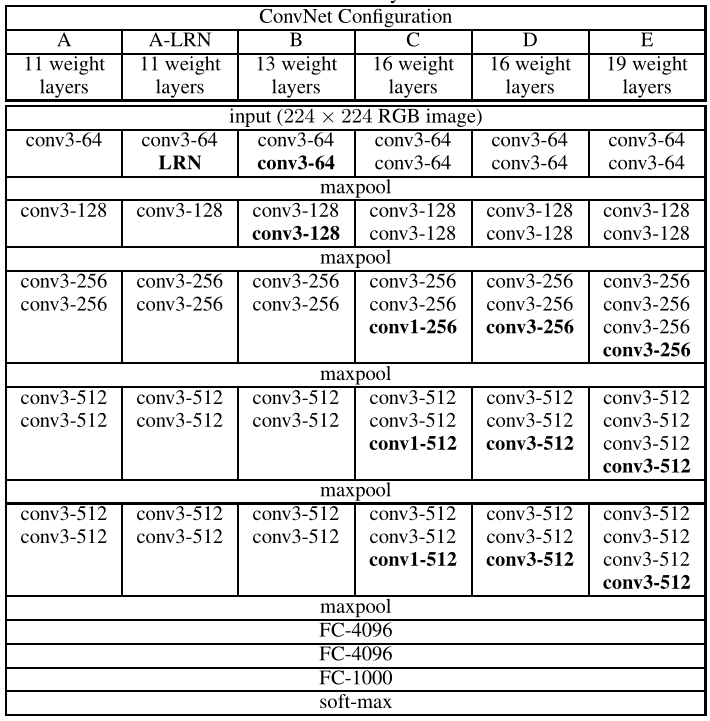

In [6]:
# VGG 原文所列架構配置表
Image(filename='images/vgg_configurations.png', width=450)

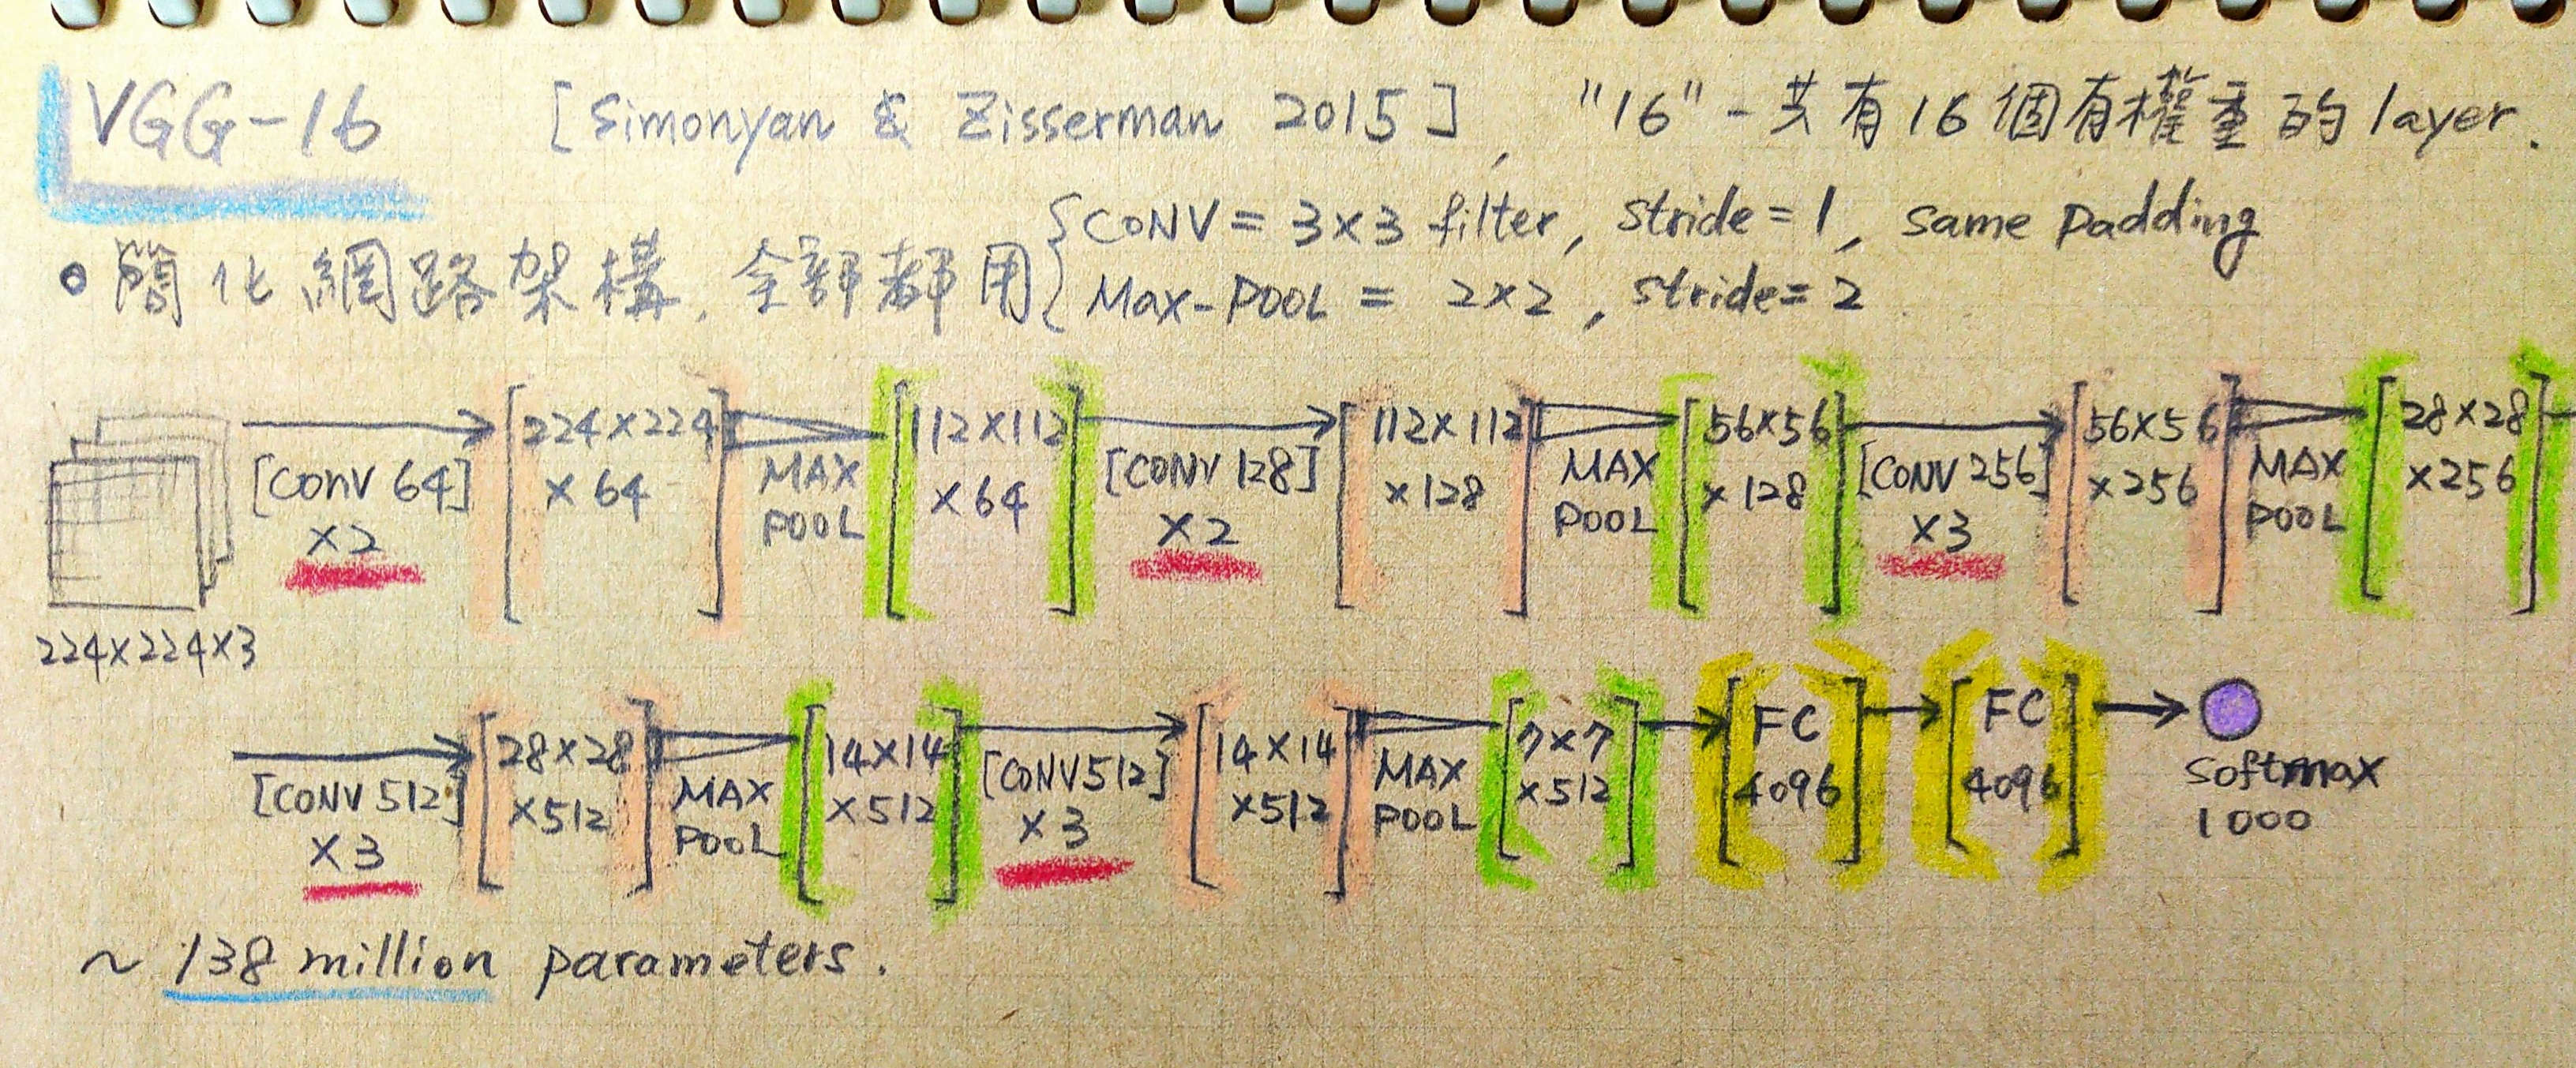

In [2]:
Image(filename='images/vgg16_architecture.jpg', width=800)

---

<a id="vgg-model"></a>

### § VGG model in `torchvision`

[**`torchvision.model`**](https://pytorch.org/vision/stable/models.html) 中包含了VGG11、VGG13、VGG16、VGG19 的實作類別，以及[預訓練過 ImageNet](https://pytorch.org/hub/pytorch_vision_vgg/) 的參數。 以下 VGG 模型實作的程式碼僅供參考，實際要使用時直接自 `torchvision.models` import 就可以了。

```
import torchvision.models as models

vgg16 = models.vgg16()

vgg19_pretrained = models.vgg19(pretrained=True)

```

由於 VGG 重複簡單的架構，所以對於如何定義出架構可參數調整的模型類別，這個實作也是個很好的範例。


In [ ]:
# The following VGG model code is copied from torchvision.model
# https://github.com/pytorch/vision/blob/master/torchvision/models/vgg.py
import torch
import torch.nn as nn
from typing import Union, List, Dict, Any, cast

cfgs: Dict[str, List[Union[str, int]]] = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

def make_layers(cfg: List[Union[str, int]], batch_norm: bool = False) -> nn.Sequential:
    layers: List[nn.Module] = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            v = cast(int, v)
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


class VGG(nn.Module):

    def __init__(
        self,
        features: nn.Module,
        num_classes: int = 1000,
        init_weights: bool = True
    ) -> None:
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        if init_weights:
            self._initialize_weights()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

# 簡化過原始程式碼的 vgg16
def vgg16(batch_norm: bool, **kwargs: Any) -> VGG:
    model = VGG(make_layers(cfgs['D'], batch_norm=batch_norm), **kwargs)
    return model


---

<a id="google-net"></a>

## 4.3 GoogLeNet (Inception)

**GoogLeNet** [[7]](#references) 是 [ILSVRC 2014](https://image-net.org/challenges/LSVRC/2014/) 的獲勝模型，受 "*Network in Network*" [[6]](#references) 架構的啟發，延伸發展了名為 **Inception** 的建構模組，之後又陸續發表了幾代的改進版本 *Inception v2*、 *Inception v3*、...等。 由於 Inception 模組中用了許多 1×1 的捲積操作，以下先簡介 1×1 Convolution 的作用。


<a id="1x1-conv"></a>

### § 1×1 Convolution

一般捲積的操作，是經由設計過的 kernel 來取相鄰像素之間的關係作為特徵。 Kernel 1×1 的捲積操作只針對單一像素位置，乍聽之下似乎沒什麼用處，一開始被提出應用於 "*Network in Network*" [[6]](#references) 的架構設計中，又經過幾個經典網路的巧妙運用，**1×1 Convolution**才普遍被注意到原來也是不錯的工具，特點歸納如下：

+ 若從 channel 的維度觀察，1×1 Convolution 在每個像素位置各自形成一個全連結層，各自輸出到一單獨神經元，但看起來又像是多層的 MLP 串起輸出的 feature map，所以稱為網路中的網路。
+ 傳統 LeNet 和 AlexNet 所採用的特徵學習機＋分類器的架構，會先經過 flatten 轉換再串聯到全連接層，有可能會破壞原本特徵的空間關係。 1×1 Convolution 可以用來取代全連接層。
+ 一般的 Conv → Pooling 結構只能調整 feature map 長寬的維度大小（H×W），1×1 Convolution 可以用來調整通道維度的大小（C）。


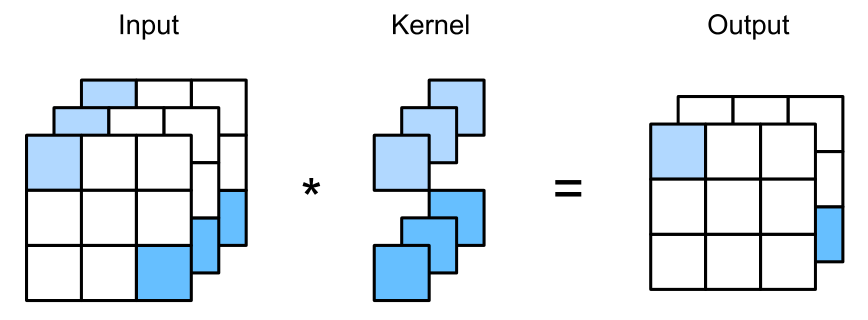

In [10]:
# 圖例來源： "Dive into Deep Learning" （參考書目[2]）
# 1×1 Convolution
Image(filename='images/1x1conv.png', width=500)

<a id="inception-architecture"></a>

### § Inception 基本結構

**Inception** 模組的設計思路與 VGG 不同，以往要設計 CNN 網路架構時，要如何決定 kernel 大小（reception field）沒有什麼規則可循。 VGG 只採用 3×3 堆疊很多層來簡化設計，但傳統的影像處理領域裡，就有著使用多重 scale 濾波器進行處理的知名技術，所以為什麼 CNN 裡不乾脆就同時使用多種 scale 的 kernel？

基於這樣的想法，在 Inception 模組的輸入分成四條平行的處理分支，前三條分別使用 1×1、3×3、5×5 的捲積來擷取不同 scale 的特徵，中間 3×3、5×5 的兩條分支，前面都加上一層 1×1 來降低運算的複雜度，最後一條使用 3×3 的 max pooling，後面接上 1×1 捲積來改變通道數。 所有四條分支都需要仔細計算過適當的 padding 以保證輸出入是一樣的大小，然後在模組最後將四個分支的輸出在 channel 維度上串接起來。 


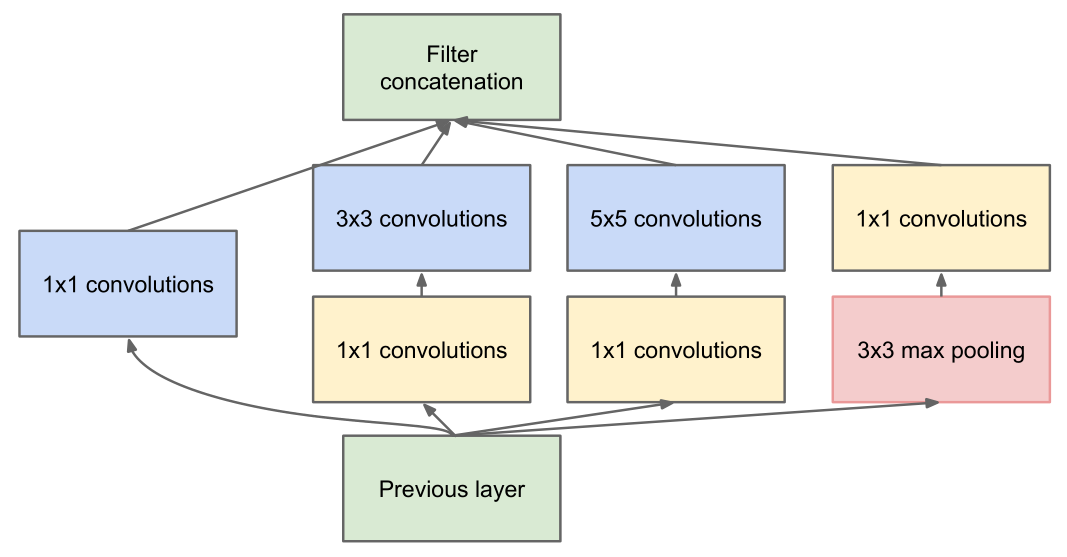

In [5]:
# GoogLeNet 原文 Figure 2: Inception module with dimensionality reduction 
Image(filename='images/inception_module.png', width=500)

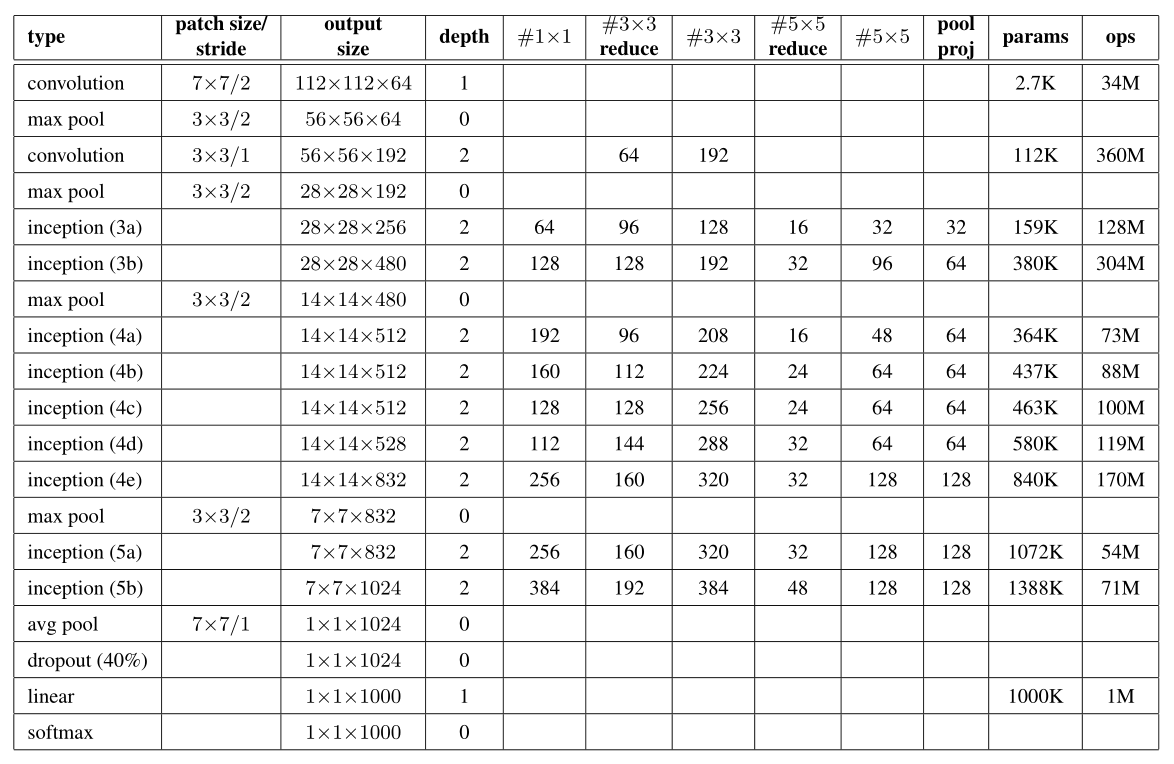

In [6]:
# GoogLeNet 原文 Table 1
Image(filename='images/googlenet_architecture.png', width=800)

<a id="googlenet-model"></a>

### § GoogLeNet model in `torchvision`

[**`torchvision.model`**](https://pytorch.org/vision/stable/models.html) 中包含了 `googlenet` 的實作類別，以及[預訓練過 ImageNet](https://pytorch.org/hub/pytorch_vision_googlenet/) 的參數。 值得注意的是，Inception模組的組合設計雖然較複雜，但卻是非常高效率的，可以在較少的參數量、花費較少的運算資源下得到不錯的預測品質。

```
import torchvision.models as models

googlenet = models.googlenet()

googlenet_pretrained = models.googlenet(pretrained=True)

```

完整 GoogLeNet 實作請參閱 [`torchvsion.model.GoogLeNet`](https://github.com/pytorch/vision/blob/master/torchvision/models/googlenet.py)。

---

<a id="res-net"></a>

## 4.4 ResNet

自從 2012 年以來的深度學習熱潮，普遍的認知都是越深層越有助於降低學習的誤差，但是實務上許多人嘗試的結果並非如此。 以當時常用的一般網路結構堆疊的網路，發現越深的網路學習能力反而衰減。 而這個現象並非過度擬合造成的，因為與較淺層的網路相比，深層網路在訓練時期就已經發現學習誤差反而比較大。

**ResNet** [[8]](#references) 是 [ILSVRC 2015](https://image-net.org/challenges/LSVRC/2015/) 的獲勝模型，該模型首度提出了殘差學習模塊（residual block），藉由堆疊許多殘差模塊成功建構出更深層的 CNN 網路。 殘差學習的大致概念是這樣的，把一般網路結構堆疊成的神經網路，想成是許多函數合成的一個對應的複合函數，原本一般網路 $\ell$ 層的輸入 $\mathbf{x}_{\ell}$ 經過函數 $f_{\ell}(\mathbf{x}_{\ell})$ 輸出 $\mathbf{x}_{\ell + 1}$，若是換成

$$
    \mathbf{x}_{\ell + 1} = a \left( \mathbf{x}_{\ell} + f_{\ell}(\mathbf{x}_{\ell}) \right)
$$

則這一層的函數映射只需要學與前一層的差，這樣的學習任務應該相對簡單。


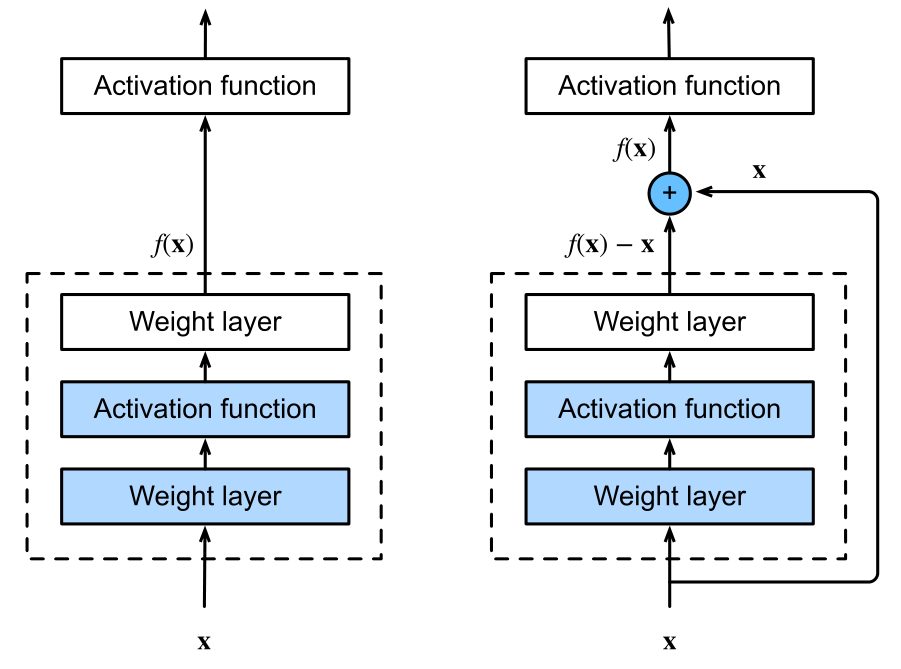

In [2]:
# 圖例來源： "Dive into Deep Learning" （參考書目[2]）
# 左邊一般網路結構，右邊有捷徑連結的殘差模塊
Image(filename='images/residual_block.png', width=400)

<a id="resnet-architecture"></a>

### § ResNet 基本結構

**ResNet** 延續 VGG 用簡單結構堆疊深層的手法，都採用 $3 \times 3$ 捲積 kernel 為基本結構，每個殘差模塊裡的 $f(\mathbf{x})$ 都是相同的 `3×3 Conv` → `BatchNorm` → `ReLU` → `3×3 Conv` → `BatchNorm` 結構模式。 由於輸入 $\mathbf{x}$ 與殘差模塊輸出 $f(\mathbf{x})$ 要相加的要求是形狀要相同，所以輸出的通道數改變時需要透過一個額外的 `1×1 Conv` 來處理。

ResNet 以輸出的 feature map 大小來定義殘差網路的一個層，除了第一層的 $112 \times 112$ 與最後的全連接層以外，主要有四個殘差模塊組成的層，分別是輸出 feature map $56 \times 56$、$28 \times 28$、$14 \times 14$、$7 \times 7$。 每個層會重複使用多次殘差模塊，以有權重參數的層數計算來命名的話，ResNet 分為了 **`resnet18`**、**`resnet34`**、**`resnet50`**、**`resnet101`**、以及 **`resnet152`** 五種設計。


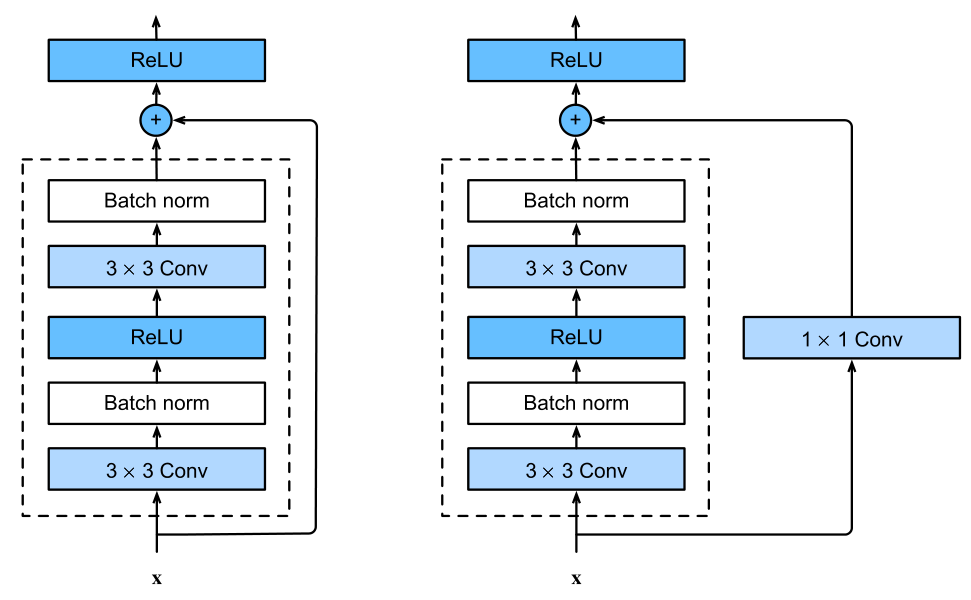

In [9]:
# 圖例來源： "Dive into Deep Learning" （參考書目[2]）
# 左邊標準殘差模塊，右邊以 1×1 Conv 來調整通道數
Image(filename='images/residual_block_with_1x1conv.png', width=500)

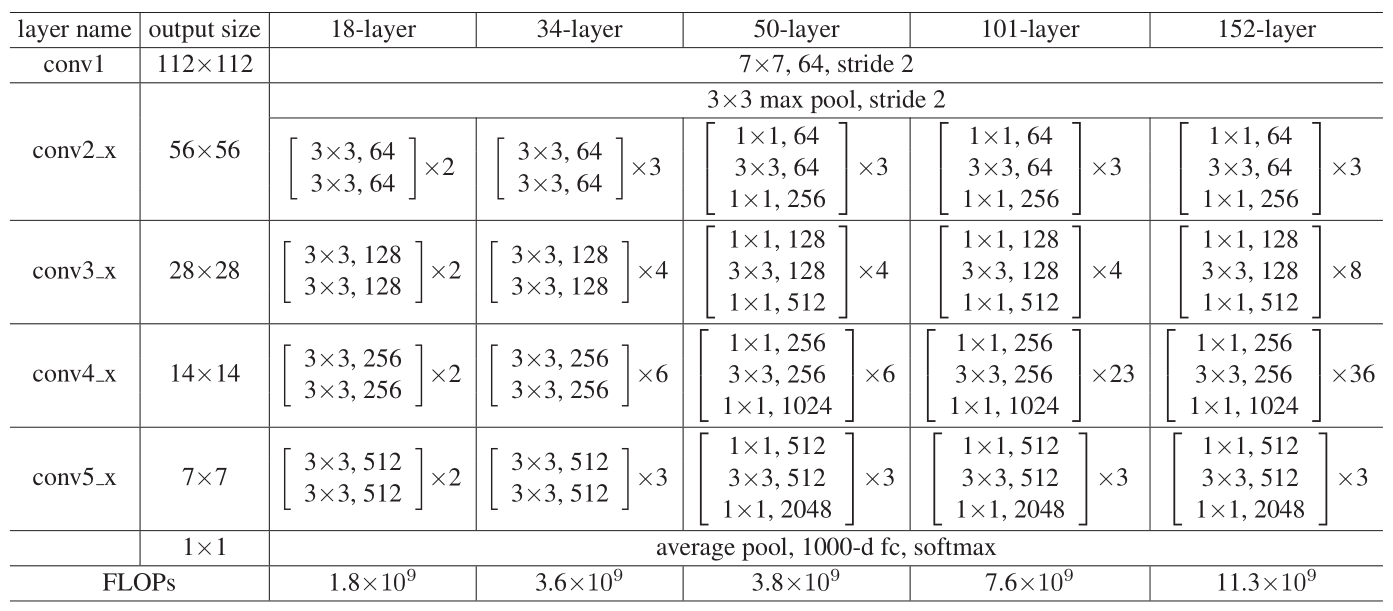

In [4]:
# ResNet 原文五種架構設計表
Image(filename='images/resnet_all_architectures.png', width=800)

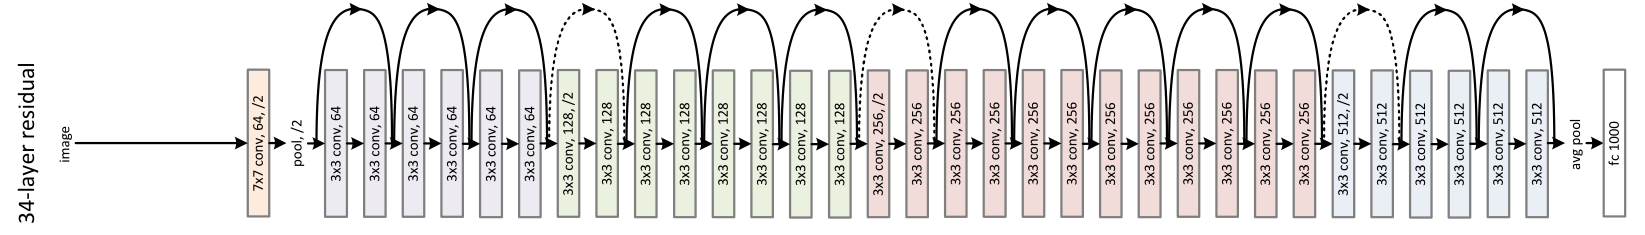

In [2]:
# ResNet 原文 34 層架構圖例
Image(filename='images/resnet34_architecture.png', width=1024)


<a id="resnet-model"></a>

### § ResNet model in `torchvision`

[**`torchvision.model`**](https://pytorch.org/vision/stable/models.html) 中包含了 `resnet18`、`resnet34`、`resnet50`、`resnet101`、以及 `resnet152`的實作類別，以及[預訓練過 ImageNet](https://pytorch.org/hub/pytorch_vision_resnet/) 的參數。

```
import torchvision.models as models

resnet101 = models.resnet101()

resnet50_pretrained = models.resnet50(pretrained=True)

```

以下 ResidualBlock 實作的程式碼僅供參考，完整 ResNet 實作請參閱 [`torchvsion.model.ResNet`](https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py)。

In [ ]:
# example ResidualBlock only
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from typing import Type, Any, Callable, Union, List, Optional

def conv3x3(in_channels: int, out_channels: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)

def conv1x1(in_channels: int, out_channels: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_channels, out_planes, kernel_size=1, stride=stride, bias=False)

class ResidualBlock(nn.Module):
    
    def __init__(self, in_channels: int, out_channels: int, stride: int = 1, downsample: bool=False):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        if downsample:
            self.downsample = conv1x1(in_channels, out_channels, stride)
        else:
            self.downsample = None
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x
        
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = F.relu(out)

        return out


---

<a id="transfer-learning"></a>

## 4.5 Transfer Learning

產業界實際在運用深度學習模型時，因為很難有足夠的資料集，通常也不容易有充足的計算硬體資源，所以比較少人是把模型從頭訓練起的。 常見的作法就是拿現成已經訓練過大型資料集（如: ImageNet）的模型：
1. 用原本的權重當作初時值，加速收斂速度。 或是，
2. 固定原始權重不變，把輸出之前的捲積層拿來當做特徵擷取機。


In [ ]:
from pathlib import Path
from typing import Union
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_and_extract_archive
import pytorch_lightning as pl

class CatDogImageDataModule(pl.LightningDataModule):

    URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

    def __init__(self, data_dir: Union[str, Path] = 'data', num_workers: int = 0, batch_size: int = 32):
        """CatDogImageDataModule

        Args:
            data_dir: root directory where to download the data
            num_workers: number of CPU workers
            batch_size: number of sample in a batch
        """
        super().__init__()
        self._data_dir = data_dir
        self._num_workers = num_workers
        self._batch_size = batch_size

    def prepare_data(self):
        """Download images and prepare images datasets."""
        download_and_extract_archive(url=self.URL, download_root=self._data_dir, remove_finished=False)

    @property
    def data_path(self):
        return Path(self._data_dir).joinpath('cats_and_dogs_filtered')

    @property
    def train_transform(self):
        return transforms.Compose([
            transforms.RandomResizedCrop((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    @property
    def valid_transform(self):
        return transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def train_dataloader(self):
        dataset = ImageFolder(root=self.data_path.joinpath('train'), transform=self.train_transform)
        return DataLoader(dataset=dataset, batch_size=self._batch_size, num_workers=self._num_workers, shuffle=True)

    def val_dataloader(self):
        dataset = ImageFolder(root=self.data_path.joinpath('validation'), transform=self.valid_transform)
        return DataLoader(dataset=dataset, batch_size=self._batch_size, num_workers=self._num_workers, shuffle=False)


In [ ]:
import pytorch_lightning as pl
import torch.nn.functional as F
import torchmetrics.functional as FM
from torchvision import models
from torch import nn, optim

class TransferLearningModel(pl.LightningModule):

    def __init__(
        self,
        backbone: str = 'resnet50',
        train_bn: bool = False,
        milestones: tuple = (2, 4),
        batch_size: int = 32,
        lr: float = 1e-3,
        lr_scheduler_gamma: float = 1e-1,
        num_workers: int = 4,
        **kwargs
    ):
        """TransferLearningModel

        Args:
            backbone: Name (as in ``torchvision.models``) of the feature extractor
            train_bn: Whether the BatchNorm layers should be trainable
            milestones: List of two epochs milestones
            lr: Initial learning rate
            lr_scheduler_gamma: Factor by which the learning rate is reduced at each milestone
        """
        super().__init__()
        self.backbone = backbone
        self.train_bn = train_bn
        self.milestones = milestones
        self.batch_size = batch_size
        self.lr = lr
        self.lr_scheduler_gamma = lr_scheduler_gamma
        self.num_workers = num_workers
        self.save_hyperparameters()

        # Load pre-trained network
        model_func = getattr(models, self.backbone)
        backbone = model_func(pretrained=True)
        # feature extractor
        _layers = list(backbone.children())[:-1]
        self.feature_extractor = nn.Sequential(*_layers)
        # classifier:
        self.fc = nn.Linear(backbone.fc.in_features, 1)

    def forward(self, x):
        out = self.feature_extractor(x)
        out = out.squeeze(-1).squeeze(-1)
        y_hat = self.fc(out)
        return y_hat

    def loss(self, logits, labels):
        return F.binary_cross_entropy_with_logits(input=logits, target=labels)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_logits = self.forward(x)
        y_scores = F.sigmoid(y_logits)
        y_true = y.view((-1, 1)).type_as(x)

        train_loss = self.loss(y_logits, y_true)
        self.log('train_acc', FM.accuracy(y_scores, y_true.int()), prog_bar=True)

        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_logits = self.forward(x)
        y_scores = F.sigmoid(y_logits)
        y_true = y.view((-1, 1)).type_as(x)

        self.log('val_loss', self.loss(y_logits, y_true), prog_bar=True)
        self.log('val_acc', FM.accuracy(y_scores, y_true.int()), prog_bar=True)

    def configure_optimizers(self):
        parameters = list(self.parameters())
        trainable_parameters = list(filter(lambda p: p.requires_grad, parameters))
        pl.utilities.rank_zero_info(
            f'The model will start training with only {len(trainable_parameters)} '
            f'trainable parameters out of {len(parameters)}.'
        )
        optimizer = optim.Adam(trainable_parameters, lr=self.lr)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.milestones, gamma=self.lr_scheduler_gamma)
        return [optimizer], [scheduler]


In [ ]:
import pytorch_lightning as pl
from torch.optim.optimizer import Optimizer
from pytorch_lightning.callbacks.finetuning import BaseFinetuning

class MilestonesFinetuning(BaseFinetuning):

    def __init__(self, milestones: tuple = (5, 10), train_bn: bool = False):
        super().__init__()
        self.milestones = milestones
        self.train_bn = train_bn

    def freeze_before_training(self, pl_module: pl.LightningModule):
        self.freeze(modules=pl_module.feature_extractor, train_bn=self.train_bn)

    def finetune_function(self, pl_module: pl.LightningModule, epoch: int, optimizer: Optimizer, opt_idx: int):
        if epoch == self.milestones[0]:
            # unfreeze 5 last layers
            self.unfreeze_and_add_param_group(
                modules=pl_module.feature_extractor[-5:], optimizer=optimizer, train_bn=self.train_bn
            )
        elif epoch == self.milestones[1]:
            # unfreeze remaining layers
            self.unfreeze_and_add_param_group(
                modules=pl_module.feature_extractor[:-5], optimizer=optimizer, train_bn=self.train_bn
            )

In [ ]:
import os
import pytorch_lightning as pl

def main(args):
    DATASET_DIR = '../../data/Cats_and_Dogs'
    NUM_WORKERS = int(os.cpu_count() / 2)
    BATCH_SIZE = 32

    catdog_dm = CatDogImageDataModule(data_dir=DATASET_DIR, num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)
    tl_model = TransferLearningModel(backbone='resnet18', num_workers=NUM_WORKERS, batch_size=BATCH_SIZE)

    finetuning_callback = MilestonesFinetuning(milestones=(5, 10), train_bn=True)
    trainer = pl.Trainer.from_argparse_args(args, callbacks=[finetuning_callback])

    trainer.fit(model=tl_model, datamodule=catdog_dm)


In [ ]:
from argparse import ArgumentParser
import pytorch_lightning as pl

# 寫在 script 檔時請改成用 if __name__ == '__main__'
#if __name__ == '__main__':
if True:
    parser = ArgumentParser()
    parser = pl.Trainer.add_argparse_args(parser)
    # 寫在 script 檔時請改成用 args = parser.parse_args()
    args = parser.parse_args(['--weights_summary', 'full',
                              '--check_val_every_n_epoch', '1',
                              '--max_epochs', '15',
                              '--gpus', '1',
                              '--num_sanity_val_steps', '0',
                              '--accelerator', 'dp'])

    main(args)

---

<a id="references"></a>

## References:

- [1]. Kevin P. Murphy. "*Probabilistic Machine Learning: An introduction*". MIT press (2021). [[link]](https://probml.github.io/pml-book/book1.html)
- [2]. Aston Zhang, Zachary Lipton, Mu Li, and Alexander Smola. "*Dive into Deep Learning*", PyTorch edition (2021). [[link]](https://d2l.ai/d2l-en-pytorch.pdf)
- [3]. Alex Krizhevsky, Ilya Sutskever, and Geoffrey E. Hinton. "*Imagenet classification with deep convolutional neural networks.*" In: NIPS (2012).
- [4]. Alex Krizhevsky. "*One weird trick for parallelizing convolutional neural networks.*" arXiv:1404.5997 (2014).
- [5]. Karen Simonyan, and Andrew Zisserman. "*Very deep convolutional networks for large-scale image recognition.*" arXiv:1409.1556 (2014).
- [6]. Min Lin, Qiang Chen, and Shuicheng Yan. "*Network in network.*" arXiv:1312.4400 (2013).
- [7]. Christian Szegedy et al. "*Going Deeper with Convolutions*". In: CVPR (2015).
- [8]. Kaiming He et al. "*Deep residual learning for image recognition.*" In: CVPR (2016).
- [9]. CS231n Notes: "*Transfer Learning*", CS231n Convolutional Neural Networks for Visual Recognition, Stanford, spring 2021. [[link]](https://cs231n.github.io/transfer-learning/)

---

**June, 2021**

***James Chang***